In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import math

## Read Data

In [2]:
data_path = "../data/"

In [3]:
nifty50_stocks = ["COALINDIA", "HINDALCO", "TATASTEEL", "UPL", "SBILIFE", "HDFCLIFE", "ONGC", "JSWSTEEL", "TITAN", "M&M", 
                  "POWERGRID", "ADANIPORTS", "WIPRO", "RELIANCE", "TATAMOTORS", "CIPLA", "ITC", "NESTLEIND", "AXISBANK", 
                  "TCS", "TECHM", "BRITANNIA", "HCLTECH", "INFY", "NTPC", "DIVISLAB", "EICHERMOT", "BAJAJFINSV", "LT", 
                  "IOC", "TATACONSUM", "BPCL", "BHARTIARTL", "HINDUNILVR", "SUNPHARMA", "SHREECEM", "DRREDDY", "INDUSINDBK", 
                  "HDFC", "SBIN", "ULTRACEMCO", "BAJFINANCE", "GRASIM", "KOTAKBANK", "HEROMOTOCO", "BAJAJ-AUTO", "HDFCBANK", 
                  "ICICIBANK", "ASIANPAINT", "MARUTI"]

In [4]:
dataset = {}

In [5]:
for stock in nifty50_stocks:
    data = pd.read_csv(data_path + stock + ".csv", names=['Date', 'Open', 'High', 'Low', 'Close', 'Value', 'Volume', 'Trades'])
    dataset[stock] = data

## Check for missing values

In [6]:
for stock in nifty50_stocks:
    data = dataset[stock]
    null_cols = data.columns[data.isna().any()].tolist()
    if len(null_cols) > 0:
        print(f"Found missing values in {stock} for column {null_cols}")

In [52]:
temp = dataset["TCS"]
temp

,Date,Open,High,Low,Close,Value,Volume,Trades,body,top_wick,bottom_wick,RVolume,Cluster Label
1,30117,2361.25,2371.70,2343.30,2368.25,1.739432e+09,737662,42941,0.002965,1163.758929,6054.919643,0.792330,13
2,40117,2369.70,2388.85,2358.30,2379.50,1.685775e+09,710033,42460,0.004136,2260.887245,2756.589796,-0.037455,20
3,50117,2384.00,2389.95,2320.40,2334.40,2.605874e+09,1108202,86774,-0.020805,285.983871,672.903226,0.560775,28
4,60117,2321.00,2329.35,2257.10,2281.40,3.442589e+09,1504948,61868,-0.017062,489.402778,1424.250000,0.358009,28
5,90117,2275.00,2311.30,2257.00,2303.70,2.118304e+09,927289,46261,0.012615,602.439024,1426.829268,-0.383840,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,220222,3650.00,3667.90,3570.00,3586.40,1.945335e+10,5408531,334519,-0.017425,1027.279874,941.194969,-0.275571,17
1273,230222,3611.00,3622.90,3555.65,3563.80,8.689550e+09,2426203,166091,-0.013071,910.400424,623.509534,-0.551412,17
1274,240222,3474.00,3483.85,3391.10,3401.65,1.733735e+10,5039136,344070,-0.020826,472.963372,506.574983,1.076964,28
1275,250222,3468.00,3530.00,3462.00,3520.75,8.945213e+09,2549723,178046,0.015210,608.132701,394.464455,-0.494016,29


## Model Candle 

In [9]:
for stock in nifty50_stocks:
    data = dataset[stock]
    data['body'] = (data['Close'] - data['Open'])/data['Open']
    data['top_wick'] = data.apply(lambda d : (d['High'] - d['Close']) if (d['Close'] > d['Open']) else (d['High'] - d['Open']), 
                                  axis=1)
    data['top_wick'] = data.apply(lambda d : d['top_wick']/0.01 if d['body'] == 0 else d['top_wick']/abs(d['body']), axis=1)
    data['bottom_wick'] = data.apply(lambda d : (d['Open'] - d['Low']) if (d['Close'] > d['Open']) else (d['Close'] - d['Low']), 
                                  axis=1)
    data['bottom_wick'] = data.apply(lambda d : d['bottom_wick']/0.01 if d['body'] == 0 else d['bottom_wick']/abs(d['body']), 
                                     axis=1)
    data['RVolume'] = (data['Volume'] - data['Volume'].shift(1)) / data['Volume'].shift(1)
   

## Create combined dataset for clustering

In [10]:
cluster_dataset = pd.DataFrame()
for stock in nifty50_stocks:
    data = dataset[stock]
    data_temp = data[['body', 'top_wick', 'bottom_wick', 'RVolume']].copy()
    if cluster_dataset.empty:
        cluster_dataset = data_temp.copy()
    else:
        cluster_dataset = pd.concat([cluster_dataset, data_temp])

In [11]:
cluster_dataset.dropna(inplace=True)

In [12]:
cluster_dataset

,body,top_wick,bottom_wick,RVolume
1,0.014286,140.000000,105.000000,-0.155905
2,0.000490,7854.000000,1122.000000,0.338985
3,0.003908,793.341667,127.958333,-0.055675
4,-0.009061,171.053571,132.428571,-0.490688
5,-0.019127,5.228205,20.912821,1.071799
...,...,...,...,...
1272,0.015044,2459.428795,7321.785994,-0.008340
1273,0.001018,89452.994350,34170.847458,-0.101274
1274,-0.022834,8112.955434,2415.273912,0.697902
1275,0.011634,9446.139438,4336.285120,0.419055


## Normalizing data

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_data = scaled = scaler.fit_transform(cluster_dataset)

In [15]:
std_data

array([[ 0.80170672, -0.03429583, -0.0458217 , -0.25886196],
       [ 0.06873715, -0.00704196, -0.04087763,  0.08710478],
       [ 0.25030306, -0.03198755, -0.04571009, -0.18879327],
       ...,
       [-1.17049252, -0.00612706, -0.03459049,  0.33801536],
       [ 0.66083884, -0.00141687, -0.02525164,  0.14307966],
       [ 0.13327128,  0.01867705,  0.48377578, -0.34905882]])

## Clustering - K means - finding K

In [16]:
sum_of_squared_distances = []
K = range(5,100)
for k in K:
    print(f"Running for K = {k}")
    km = KMeans(n_clusters=k)
    km = km.fit(std_data)
    sum_of_squared_distances.append(km.inertia_)

Running for K = 5
Running for K = 6
Running for K = 7
Running for K = 8
Running for K = 9
Running for K = 10
Running for K = 11
Running for K = 12
Running for K = 13
Running for K = 14
Running for K = 15
Running for K = 16
Running for K = 17
Running for K = 18
Running for K = 19
Running for K = 20
Running for K = 21
Running for K = 22
Running for K = 23
Running for K = 24
Running for K = 25
Running for K = 26
Running for K = 27
Running for K = 28
Running for K = 29
Running for K = 30
Running for K = 31
Running for K = 32
Running for K = 33
Running for K = 34
Running for K = 35
Running for K = 36
Running for K = 37
Running for K = 38
Running for K = 39
Running for K = 40
Running for K = 41
Running for K = 42
Running for K = 43
Running for K = 44
Running for K = 45
Running for K = 46
Running for K = 47
Running for K = 48
Running for K = 49
Running for K = 50
Running for K = 51
Running for K = 52
Running for K = 53
Running for K = 54
Running for K = 55
Running for K = 56
Running for K = 5

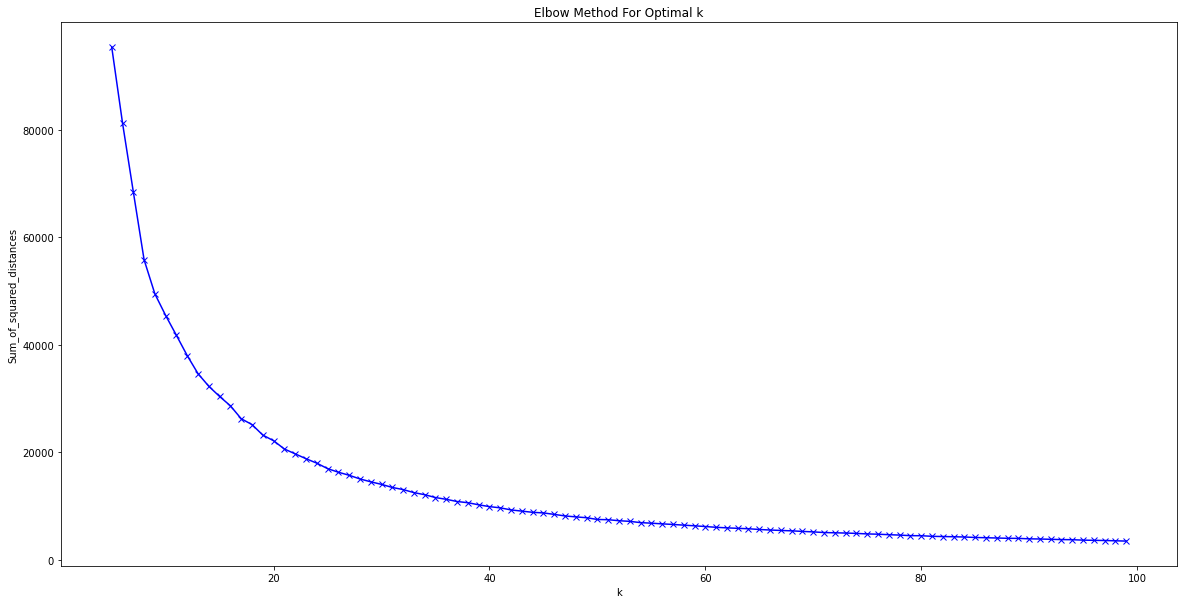

In [17]:
plt.figure(figsize=(20,10))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Cluster with K = 30

In [18]:
km = KMeans(n_clusters=30)
km = km.fit(std_data)

In [19]:
km.labels_

array([29, 13, 20, ..., 28, 29, 20])

## Allocating cluster labels to data

In [20]:
for stock in nifty50_stocks:
    data = dataset[stock]
    data.dropna(inplace=True)
    data['Cluster Label'] = km.predict(scaler.transform(data[['body', 'top_wick', 'bottom_wick', 'RVolume']]))

## Generating time series of cluster labels

In [ ]:
def parse_date(d):
    d = str(d)
    year = d[-2:]
    month = d[-4:-2]
    day = d[:-4]
    return day + "/" + month + "/" + year

In [21]:
data = dataset['TATASTEEL']
# data['ParsedDate'] = data['Date'].apply(parse_date)
# data['ParsedDate'] = pd.to_datetime(data['ParsedDate'])
data

,Date,Open,High,Low,Close,Value,Volume,Trades,body,top_wick,bottom_wick,RVolume,Cluster Label
1,30117,407.05,408.90,401.25,403.30,1.350334e+09,3338806,33408,-0.009213,200.811333,222.520667,-0.401447,1
2,40117,404.10,409.00,401.40,405.45,1.355743e+09,3344043,39997,0.003341,1062.633333,808.200000,0.001569,20
3,50117,409.10,422.50,407.30,419.30,2.998973e+09,7196279,79299,0.024933,128.345098,72.194118,1.151970,21
4,60117,420.50,425.40,415.60,419.55,1.740484e+09,4138078,53562,-0.002259,2168.894737,1748.394737,-0.424970,1
5,90117,423.70,424.20,419.35,422.00,1.318463e+09,3122769,40260,-0.004012,124.617647,660.473529,-0.245358,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,220222,1158.00,1166.65,1119.25,1138.70,1.070957e+10,9385857,222627,-0.016667,519.000000,1167.000000,0.885190,28
1273,230222,1148.00,1152.60,1134.00,1139.00,5.673217e+09,4960838,129498,-0.007840,586.755556,637.777778,-0.471456,1
1274,240222,1094.00,1119.95,1067.10,1074.00,1.328807e+10,12126867,324643,-0.018282,1419.465000,377.430000,1.444520,28
1275,250222,1097.70,1150.70,1095.60,1145.35,1.046735e+10,9212886,226899,0.043409,123.246485,48.377125,-0.240291,0


## Analyzing patterns in time series

In [22]:
cluster_timeseries = {}
cluster_timeseries_str = {}
for stock in nifty50_stocks:
    data = dataset[stock]
    ts = list(data['Cluster Label'])
    cluster_timeseries[stock] = ts
    ts_str = ' '.join(map(str, ts)).strip()
    cluster_timeseries_str[stock] = ts_str

In [53]:
km.cluster_centers_

array([[ 2.68242932e+00, -3.30968698e-02, -4.49355531e-02,
         2.76174717e-01],
       [-3.12110888e-01, -2.60031444e-02, -3.26236978e-02,
        -2.99474397e-01],
       [ 4.33326765e-02,  8.03869113e+01,  8.87030457e+01,
        -1.43169302e-01],
       [-1.50807337e+00, -3.25766562e-02, -4.11242219e-02,
         1.38817774e+00],
       [ 4.81674752e-01, -1.82579268e-02, -3.24498881e-02,
         7.87466316e+00],
       [-1.72464678e+00, -3.37012941e-02, -4.36369321e-02,
        -4.39533235e-02],
       [ 4.33235534e-02,  1.95946319e+02,  3.67730518e+01,
         2.12014930e+00],
       [ 1.43167975e+00, -3.25281533e-02, -4.39202446e-02,
        -9.92437152e-02],
       [-1.73522820e+00, -3.38882604e-02, -3.98495624e-02,
         5.43390582e+01],
       [ 4.21258496e-02,  6.45612518e+00,  7.09975812e+00,
        -1.03736817e-01],
       [ 4.28085688e-02,  1.36803121e+01,  3.18070790e+01,
        -4.13012059e-02],
       [ 6.31598130e-01, -5.97547624e-03,  1.58545554e-02,
      

In [23]:
def unique_subsequence(seq, size):
    result = []
    for i in range(0, len(seq) - size):
        if seq[i:i+size] not in result:
            result.append(seq[i:i+size])
    return result

## For sub sequence of size 3

In [24]:
size3_seq = []
for stock in nifty50_stocks:
    data = cluster_timeseries[stock]
    r = unique_subsequence(data, 3)
    for s in r:
        if s not in size3_seq:
            size3_seq.append(s)

In [25]:
len(size3_seq)

3012

In [26]:
size3_freq = {}

In [27]:
for seq in size3_seq:
    s = ' '.join(map(str,seq)).strip()
    for stock in nifty50_stocks:
        ts = cluster_timeseries_str[stock]
        s_count = ts.count(s)
        if s in size3_freq.keys():
            size3_freq[s] = s_count + size3_freq[s]
        else:
            size3_freq[s] = s_count

In [28]:
sorted_size3 = dict(sorted(size3_freq.items(), key=lambda item: item[1], reverse=True))

In [29]:
sorted_size3

{'1 20 1': 1205,
 '1 1 1': 1156,
 '0 1 1': 1153,
 '20 1 1': 1080,
 '0 20 1': 992,
 '7 1 1': 940,
 '1 29 1': 921,
 '20 20 1': 907,
 '9 1 1': 877,
 '7 1 2': 874,
 '29 1 1': 872,
 '7 20 1': 814,
 '1 13 1': 764,
 '0 13 1': 735,
 '20 13 1': 728,
 '3 1 1': 727,
 '9 20 1': 715,
 '29 20 1': 710,
 '7 29 1': 697,
 '3 20 1': 694,
 '0 29 1': 691,
 '13 1 1': 659,
 '1 17 1': 645,
 '20 29 1': 636,
 '13 20 1': 607,
 '17 1 1': 590,
 '1 28 1': 555,
 '0 17 1': 537,
 '29 29 1': 531,
 '1 1 20': 529,
 '17 20 1': 523,
 '7 17 1': 500,
 '17 29 1': 481,
 '29 17 1': 468,
 '28 20 1': 460,
 '1 20 20': 444,
 '20 17 1': 443,
 '1 1 13': 425,
 '3 29 1': 419,
 '0 28 1': 416,
 '1 20 13': 413,
 '20 28 1': 408,
 '8 1 1': 401,
 '1 13 20': 387,
 '28 1 1': 385,
 '7 13 1': 384,
 '13 29 1': 373,
 '1 1 29': 371,
 '0 1 20': 368,
 '0 1 13': 361,
 '20 1 13': 354,
 '0 13 20': 349,
 '20 13 20': 344,
 '0 20 13': 344,
 '20 1 20': 341,
 '20 20 13': 332,
 '1 1 28': 328,
 '3 17 1': 325,
 '1 29 20': 324,
 '9 1 20': 321,
 '29 1 20': 320,
 

In [46]:
total_size3_occur = sum(sorted_size3.values())

In [47]:
for (k,v) in sorted_size3.items():
    print(f"[{k}] occured with probability {v/total_size3_occur}")

[1 20 1] occured with probability 0.010538836267590236
[1 1 1] occured with probability 0.010110286079115613
[0 1 1] occured with probability 0.010084048312474309
[20 1 1] occured with probability 0.009445595990869258
[0 20 1] occured with probability 0.008675954836057688
[7 1 1] occured with probability 0.00822116688094176
[1 29 1] occured with probability 0.008054994358880171
[20 20 1] occured with probability 0.007932551447887423
[9 1 1] occured with probability 0.0076701737814743876
[7 1 2] occured with probability 0.007643936014833084
[29 1 1] occured with probability 0.007626444170405549
[7 20 1] occured with probability 0.007119180682007014
[1 13 1] occured with probability 0.0066818845713186225
[0 13 1] occured with probability 0.006428252827119355
[20 13 1] occured with probability 0.006367031371622981
[3 1 1] occured with probability 0.006358285449409213
[9 20 1] occured with probability 0.006253334382843999
[29 20 1] occured with probability 0.00620960477177516
[7 29 1] occu

[0 22 21] occured with probability 1.7491844427535663e-05
[5 20 22] occured with probability 1.7491844427535663e-05
[5 5 4] occured with probability 1.7491844427535663e-05
[20 0 18] occured with probability 1.7491844427535663e-05
[17 17 26] occured with probability 1.7491844427535663e-05
[20 1 26] occured with probability 1.7491844427535663e-05
[14 17 5] occured with probability 1.7491844427535663e-05
[14 5 18] occured with probability 1.7491844427535663e-05
[1 5 14] occured with probability 1.7491844427535663e-05
[5 14 20] occured with probability 1.7491844427535663e-05
[17 1 26] occured with probability 1.7491844427535663e-05
[18 13 7] occured with probability 1.7491844427535663e-05
[1 26 0] occured with probability 1.7491844427535663e-05
[18 20 18] occured with probability 1.7491844427535663e-05
[25 13 20] occured with probability 1.7491844427535663e-05
[14 28 1] occured with probability 1.7491844427535663e-05
[25 1 0] occured with probability 1.7491844427535663e-05
[14 1 21] occure

## For sub sequence of size 4

In [31]:
size4_seq = []
for stock in nifty50_stocks:
    data = cluster_timeseries[stock]
    r = unique_subsequence(data, 4)
    for s in r:
        if s not in size4_seq:
            size4_seq.append(s)

In [32]:
len(size4_seq)

14193

In [33]:
size4_freq = {}

In [34]:
for seq in size4_seq:
    s = ' '.join(map(str,seq)).strip()
    for stock in nifty50_stocks:
        ts = cluster_timeseries_str[stock]
        s_count = ts.count(s)
        if s in size4_freq.keys():
            size4_freq[s] = s_count + size4_freq[s]
        else:
            size4_freq[s] = s_count

In [35]:
sorted_size4 = dict(sorted(size4_freq.items(), key=lambda item: item[1], reverse=True))

In [36]:
sorted_size4

{'1 1 20 1': 250,
 '1 20 1 1': 236,
 '0 1 1 1': 231,
 '1 29 1 1': 229,
 '1 20 20 1': 226,
 '1 1 1 1': 215,
 '20 1 1 1': 212,
 '1 13 1 1': 202,
 '7 1 1 1': 201,
 '1 1 29 1': 198,
 '1 1 13 1': 194,
 '20 13 1 1': 192,
 '1 20 13 1': 190,
 '29 1 1 1': 189,
 '1 13 20 1': 179,
 '0 1 13 1': 179,
 '0 1 20 1': 178,
 '20 1 13 1': 175,
 '1 29 20 1': 175,
 '7 20 1 1': 171,
 '20 1 20 1': 170,
 '0 20 1 1': 168,
 '0 13 20 1': 167,
 '20 13 20 1': 165,
 '29 1 20 1': 165,
 '0 29 1 1': 164,
 '3 1 1 1': 162,
 '0 20 13 1': 161,
 '0 20 20 1': 161,
 '20 20 1 1': 159,
 '9 20 1 1': 156,
 '20 20 13 1': 155,
 '29 20 1 1': 155,
 '0 1 29 1': 152,
 '20 29 1 1': 151,
 '20 20 20 1': 149,
 '1 1 28 1': 149,
 '3 20 1 1': 145,
 '1 28 20 1': 144,
 '7 1 20 1': 142,
 '20 1 29 1': 140,
 '7 1 29 1': 139,
 '13 1 1 1': 139,
 '1 17 1 1': 137,
 '1 20 29 1': 137,
 '3 1 20 1': 133,
 '13 20 1 1': 131,
 '7 20 20 1': 130,
 '7 29 1 1': 129,
 '0 29 20 1': 127,
 '1 28 1 1': 124,
 '1 1 17 1': 124,
 '29 29 1 1': 123,
 '17 1 1 1': 123,
 '0 1

In [48]:
total_size4_occur = sum(sorted_size4.values())

In [49]:
for (k,v) in sorted_size4.items():
    print(f"[{k}] occured with probability {v/total_size4_occur}")

[1 1 20 1] occured with probability 0.002466748233808265
[1 20 1 1] occured with probability 0.002328610332715002
[0 1 1 1] occured with probability 0.0022792753680388367
[1 29 1 1] occured with probability 0.00225954138216837
[1 20 20 1] occured with probability 0.002229940403362671
[1 1 1 1] occured with probability 0.0021214034810751077
[20 1 1 1] occured with probability 0.002091802502269408
[1 13 1 1] occured with probability 0.001993132572917078
[7 1 1 1] occured with probability 0.001983265579981845
[1 1 29 1] occured with probability 0.0019536646011761457
[1 1 13 1] occured with probability 0.0019141966294352133
[20 13 1 1] occured with probability 0.0018944626435647473
[1 20 13 1] occured with probability 0.0018747286576942812
[29 1 1 1] occured with probability 0.001864861664759048
[1 13 20 1] occured with probability 0.0017661917354067174
[0 1 13 1] occured with probability 0.0017661917354067174
[0 1 20 1] occured with probability 0.0017563247424714843
[20 1 13 1] occured wi

[29 13 29 13] occured with probability 0.00010853692228756364
[13 7 20 20] occured with probability 0.00010853692228756364
[21 1 7 1] occured with probability 0.00010853692228756364
[17 29 1 7] occured with probability 0.00010853692228756364
[13 1 17 20] occured with probability 0.00010853692228756364
[4 1 20 1] occured with probability 0.00010853692228756364
[20 13 28 20] occured with probability 0.00010853692228756364
[3 20 7 17] occured with probability 0.00010853692228756364
[3 28 20 29] occured with probability 0.00010853692228756364
[13 12 20 1] occured with probability 0.00010853692228756364
[13 20 29 28] occured with probability 0.00010853692228756364
[7 17 5 20] occured with probability 0.00010853692228756364
[21 20 20 29] occured with probability 0.00010853692228756364
[29 13 13 20] occured with probability 0.00010853692228756364
[29 5 17 1] occured with probability 0.00010853692228756364
[7 1 29 5] occured with probability 0.00010853692228756364
[28 1 12 1] occured with prob

[5 29 7 5] occured with probability 4.933496467616529e-05
[28 20 29 5] occured with probability 4.933496467616529e-05
[1 7 7 29] occured with probability 4.933496467616529e-05
[1 13 29 7] occured with probability 4.933496467616529e-05
[17 7 28 17] occured with probability 4.933496467616529e-05
[7 29 20 3] occured with probability 4.933496467616529e-05
[28 13 5 1] occured with probability 4.933496467616529e-05
[21 17 7 1] occured with probability 4.933496467616529e-05
[21 29 1 29] occured with probability 4.933496467616529e-05
[22 20 29 1] occured with probability 4.933496467616529e-05
[1 20 25 20] occured with probability 4.933496467616529e-05
[28 13 7 1] occured with probability 4.933496467616529e-05
[17 13 17 3] occured with probability 4.933496467616529e-05
[1 1 17 0] occured with probability 4.933496467616529e-05
[7 28 20 5] occured with probability 4.933496467616529e-05
[20 13 7 13] occured with probability 4.933496467616529e-05
[29 29 21 5] occured with probability 4.933496467616

[13 12 17 12] occured with probability 1.9733985870466117e-05
[12 29 20 17] occured with probability 1.9733985870466117e-05
[17 29 14 20] occured with probability 1.9733985870466117e-05
[14 20 1 28] occured with probability 1.9733985870466117e-05
[13 29 29 4] occured with probability 1.9733985870466117e-05
[20 29 28 0] occured with probability 1.9733985870466117e-05
[28 0 20 13] occured with probability 1.9733985870466117e-05
[21 1 5 0] occured with probability 1.9733985870466117e-05
[17 29 11 17] occured with probability 1.9733985870466117e-05
[29 11 17 29] occured with probability 1.9733985870466117e-05
[20 17 29 25] occured with probability 1.9733985870466117e-05
[29 25 7 7] occured with probability 1.9733985870466117e-05
[17 29 20 25] occured with probability 1.9733985870466117e-05
[25 17 20 13] occured with probability 1.9733985870466117e-05
[1 1 11 20] occured with probability 1.9733985870466117e-05
[29 4 17 29] occured with probability 1.9733985870466117e-05
[1 25 7 20] occured 

[12 5 0 5] occured with probability 9.866992935233059e-06
[0 5 20 12] occured with probability 9.866992935233059e-06
[5 20 12 29] occured with probability 9.866992935233059e-06
[20 12 29 5] occured with probability 9.866992935233059e-06
[12 29 5 20] occured with probability 9.866992935233059e-06
[7 13 17 4] occured with probability 9.866992935233059e-06
[17 4 20 20] occured with probability 9.866992935233059e-06
[4 20 20 12] occured with probability 9.866992935233059e-06
[28 1 0 28] occured with probability 9.866992935233059e-06
[28 17 7 4] occured with probability 9.866992935233059e-06
[17 7 4 1] occured with probability 9.866992935233059e-06
[7 4 1 20] occured with probability 9.866992935233059e-06
[4 1 20 4] occured with probability 9.866992935233059e-06
[4 20 20 20] occured with probability 9.866992935233059e-06
[21 12 20 12] occured with probability 9.866992935233059e-06
[12 20 12 7] occured with probability 9.866992935233059e-06
[20 12 7 0] occured with probability 9.866992935233

[0 22 0 17] occured with probability 9.866992935233059e-06
[22 0 17 1] occured with probability 9.866992935233059e-06
[5 17 26 0] occured with probability 9.866992935233059e-06
[17 26 0 18] occured with probability 9.866992935233059e-06
[26 0 18 5] occured with probability 9.866992935233059e-06
[14 17 17 7] occured with probability 9.866992935233059e-06
[29 20 1 25] occured with probability 9.866992935233059e-06
[1 25 29 22] occured with probability 9.866992935233059e-06
[25 29 22 5] occured with probability 9.866992935233059e-06
[22 5 17 17] occured with probability 9.866992935233059e-06
[1 21 1 22] occured with probability 9.866992935233059e-06
[21 1 22 20] occured with probability 9.866992935233059e-06
[1 21 0 7] occured with probability 9.866992935233059e-06
[20 17 5 9] occured with probability 9.866992935233059e-06
[17 5 9 20] occured with probability 9.866992935233059e-06
[5 9 20 29] occured with probability 9.866992935233059e-06
[20 17 13 22] occured with probability 9.866992935

[13 28 7 13] occured with probability 9.866992935233059e-06
[7 20 12 14] occured with probability 9.866992935233059e-06
[20 12 14 20] occured with probability 9.866992935233059e-06
[12 14 20 20] occured with probability 9.866992935233059e-06
[7 28 13 28] occured with probability 9.866992935233059e-06
[20 1 20 0] occured with probability 9.866992935233059e-06
[17 20 13 3] occured with probability 9.866992935233059e-06
[13 17 25 17] occured with probability 9.866992935233059e-06
[17 29 5 21] occured with probability 9.866992935233059e-06
[5 21 1 7] occured with probability 9.866992935233059e-06
[28 7 1 12] occured with probability 9.866992935233059e-06
[1 12 20 8] occured with probability 9.866992935233059e-06
[12 20 8 7] occured with probability 9.866992935233059e-06
[20 8 7 20] occured with probability 9.866992935233059e-06
[20 14 29 29] occured with probability 9.866992935233059e-06
[13 20 12 13] occured with probability 9.866992935233059e-06
[29 28 20 12] occured with probability 9.8

## For sub sequence of size 5

In [38]:
size5_seq = []
for stock in nifty50_stocks:
    data = cluster_timeseries[stock]
    r = unique_subsequence(data, 5)
    for s in r:
        if s not in size5_seq:
            size5_seq.append(s)

In [39]:
len(size5_seq)

36820

In [40]:
size5_freq = {}

In [41]:
for seq in size5_seq:
    s = ' '.join(map(str,seq)).strip()
    for stock in nifty50_stocks:
        ts = cluster_timeseries_str[stock]
        s_count = ts.count(s)
        if s in size5_freq.keys():
            size5_freq[s] = s_count + size5_freq[s]
        else:
            size5_freq[s] = s_count

In [42]:
sorted_size5 = dict(sorted(size5_freq.items(), key=lambda item: item[1], reverse=True))

In [43]:
sorted_size5

{'1 1 13 1 1': 68,
 '1 13 1 1 1': 57,
 '1 20 13 1 1': 56,
 '1 1 29 1 1': 54,
 '1 1 1 20 1': 53,
 '1 1 20 20 1': 53,
 '1 29 1 1 1': 51,
 '1 20 20 1 1': 51,
 '1 1 13 20 1': 49,
 '1 29 20 1 1': 47,
 '1 1 20 1 1': 47,
 '1 20 13 20 1': 46,
 '1 13 20 1 1': 46,
 '20 20 13 20 1': 44,
 '1 1 20 13 1': 44,
 '0 20 13 1 1': 43,
 '1 20 1 13 1': 42,
 '20 1 13 1 1': 42,
 '0 1 1 1 1': 42,
 '20 20 13 1 1': 41,
 '1 1 1 13 1': 41,
 '20 1 13 20 1': 41,
 '1 20 20 13 1': 40,
 '29 1 1 1 1': 40,
 '1 20 1 1 1': 40,
 '0 29 1 1 1': 40,
 '1 13 1 20 1': 39,
 '20 1 29 1 1': 39,
 '1 28 20 1 1': 38,
 '1 20 1 29 1': 38,
 '1 1 1 1 1': 38,
 '1 20 1 20 1': 38,
 '1 29 1 20 1': 38,
 '20 29 1 1 1': 38,
 '20 1 1 1 1': 38,
 '1 1 20 29 1': 37,
 '20 1 1 13 1': 37,
 '20 1 20 13 1': 37,
 '0 1 1 20 1': 37,
 '7 1 1 1 1': 36,
 '29 20 1 1 1': 36,
 '1 20 29 1 1': 36,
 '20 20 1 20 1': 35,
 '29 1 1 20 1': 34,
 '20 13 1 1 1': 34,
 '1 1 28 1 1': 34,
 '1 29 1 13 1': 33,
 '1 1 1 29 1': 33,
 '3 20 1 1 1': 33,
 '20 20 1 13 1': 33,
 '1 1 1 28 1

In [50]:
total_size5_occur = sum(sorted_size5.values())

In [51]:
for (k,v) in sorted_size5.items():
    print(f"[{k}] occured with probability {v/total_size5_occur}")

[1 1 13 1 1] occured with probability 0.0008119112151206524
[1 13 1 1 1] occured with probability 0.0006805726362040762
[1 20 13 1 1] occured with probability 0.0006686327653934785
[1 1 29 1 1] occured with probability 0.0006447530237722828
[1 1 1 20 1] occured with probability 0.000632813152961685
[1 1 20 20 1] occured with probability 0.000632813152961685
[1 29 1 1 1] occured with probability 0.0006089334113404893
[1 20 20 1 1] occured with probability 0.0006089334113404893
[1 1 13 20 1] occured with probability 0.0005850536697192937
[1 29 20 1 1] occured with probability 0.0005611739280980979
[1 1 20 1 1] occured with probability 0.0005611739280980979
[1 20 13 20 1] occured with probability 0.0005492340572875002
[1 13 20 1 1] occured with probability 0.0005492340572875002
[20 20 13 20 1] occured with probability 0.0005253543156663045
[1 1 20 13 1] occured with probability 0.0005253543156663045
[0 20 13 1 1] occured with probability 0.0005134144448557066
[1 20 1 13 1] occured with pr

[29 1 13 20 13] occured with probability 7.163922486358698e-05
[1 7 28 1 1] occured with probability 7.163922486358698e-05
[17 5 1 20 20] occured with probability 7.163922486358698e-05
[17 5 7 20 1] occured with probability 7.163922486358698e-05
[5 7 20 1 1] occured with probability 7.163922486358698e-05
[1 29 1 21 20] occured with probability 7.163922486358698e-05
[29 17 20 28 20] occured with probability 7.163922486358698e-05
[13 5 20 20 1] occured with probability 7.163922486358698e-05
[20 5 1 29 1] occured with probability 7.163922486358698e-05
[13 1 5 20 1] occured with probability 7.163922486358698e-05
[20 29 17 20 29] occured with probability 7.163922486358698e-05
[1 1 21 1 20] occured with probability 7.163922486358698e-05
[0 7 29 20 20] occured with probability 7.163922486358698e-05
[7 17 13 1 17] occured with probability 7.163922486358698e-05
[17 1 29 28 1] occured with probability 7.163922486358698e-05
[7 28 20 20 13] occured with probability 7.163922486358698e-05
[1 13 29 1

[29 20 21 29 1] occured with probability 4.7759483242391315e-05
[28 29 17 29 1] occured with probability 4.7759483242391315e-05
[17 28 28 29 1] occured with probability 4.7759483242391315e-05
[13 13 20 13 20] occured with probability 4.7759483242391315e-05
[1 21 20 29 17] occured with probability 4.7759483242391315e-05
[5 28 7 20 1] occured with probability 4.7759483242391315e-05
[20 1 5 7 1] occured with probability 4.7759483242391315e-05
[13 29 20 1 21] occured with probability 4.7759483242391315e-05
[17 20 1 17 29] occured with probability 4.7759483242391315e-05
[7 17 20 1 20] occured with probability 4.7759483242391315e-05
[1 29 13 7 29] occured with probability 4.7759483242391315e-05
[29 17 1 7 1] occured with probability 4.7759483242391315e-05
[20 20 17 28 29] occured with probability 4.7759483242391315e-05
[1 1 17 17 17] occured with probability 4.7759483242391315e-05
[1 29 29 28 20] occured with probability 4.7759483242391315e-05
[7 21 29 1 13] occured with probability 4.775948

[17 17 1 17 20] occured with probability 3.581961243179349e-05
[29 28 29 13 29] occured with probability 3.581961243179349e-05
[13 13 20 1 5] occured with probability 3.581961243179349e-05
[20 1 5 1 17] occured with probability 3.581961243179349e-05
[7 20 28 17 29] occured with probability 3.581961243179349e-05
[20 28 17 29 20] occured with probability 3.581961243179349e-05
[1 29 1 28 28] occured with probability 3.581961243179349e-05
[1 1 5 17 1] occured with probability 3.581961243179349e-05
[5 17 1 5 1] occured with probability 3.581961243179349e-05
[0 20 14 1 1] occured with probability 3.581961243179349e-05
[29 1 1 17 7] occured with probability 3.581961243179349e-05
[13 1 29 20 29] occured with probability 3.581961243179349e-05
[1 20 17 14 17] occured with probability 3.581961243179349e-05
[20 29 29 17 29] occured with probability 3.581961243179349e-05
[17 29 1 20 29] occured with probability 3.581961243179349e-05
[13 29 13 1 17] occured with probability 3.581961243179349e-05
[13

[25 1 20 3 20] occured with probability 2.3879741621195657e-05
[28 20 29 28 20] occured with probability 2.3879741621195657e-05
[13 1 20 28 21] occured with probability 2.3879741621195657e-05
[1 20 28 21 20] occured with probability 2.3879741621195657e-05
[28 21 20 1 1] occured with probability 2.3879741621195657e-05
[1 12 7 1 1] occured with probability 2.3879741621195657e-05
[12 7 1 1 20] occured with probability 2.3879741621195657e-05
[28 20 21 1 20] occured with probability 2.3879741621195657e-05
[12 29 1 17 13] occured with probability 2.3879741621195657e-05
[20 20 20 20 12] occured with probability 2.3879741621195657e-05
[20 29 1 20 21] occured with probability 2.3879741621195657e-05
[29 7 29 20 20] occured with probability 2.3879741621195657e-05
[20 1 28 12 1] occured with probability 2.3879741621195657e-05
[20 20 20 21 7] occured with probability 2.3879741621195657e-05
[20 21 7 5 1] occured with probability 2.3879741621195657e-05
[5 1 17 20 20] occured with probability 2.387974

[29 1 7 20 29] occured with probability 2.3879741621195657e-05
[1 29 1 28 5] occured with probability 2.3879741621195657e-05
[29 1 28 5 17] occured with probability 2.3879741621195657e-05
[1 17 13 25 5] occured with probability 2.3879741621195657e-05
[17 13 25 5 1] occured with probability 2.3879741621195657e-05
[5 1 20 29 1] occured with probability 2.3879741621195657e-05
[1 1 20 14 20] occured with probability 2.3879741621195657e-05
[20 14 20 29 17] occured with probability 2.3879741621195657e-05
[14 20 29 17 13] occured with probability 2.3879741621195657e-05
[29 17 13 20 12] occured with probability 2.3879741621195657e-05
[20 12 1 29 29] occured with probability 2.3879741621195657e-05
[29 29 13 17 3] occured with probability 2.3879741621195657e-05
[29 13 17 3 20] occured with probability 2.3879741621195657e-05
[13 17 3 20 20] occured with probability 2.3879741621195657e-05
[17 3 20 20 20] occured with probability 2.3879741621195657e-05
[28 28 20 13 17] occured with probability 2.38

[17 29 29 17 7] occured with probability 2.3879741621195657e-05
[7 3 5 17 20] occured with probability 2.3879741621195657e-05
[21 5 5 1 5] occured with probability 2.3879741621195657e-05
[1 5 28 7 20] occured with probability 2.3879741621195657e-05
[1 17 13 5 7] occured with probability 2.3879741621195657e-05
[0 29 0 5 17] occured with probability 2.3879741621195657e-05
[0 5 17 29 28] occured with probability 2.3879741621195657e-05
[1 29 17 1 7] occured with probability 2.3879741621195657e-05
[1 1 20 0 1] occured with probability 2.3879741621195657e-05
[0 1 1 29 7] occured with probability 2.3879741621195657e-05
[13 29 1 29 14] occured with probability 2.3879741621195657e-05
[29 1 29 14 17] occured with probability 2.3879741621195657e-05
[1 29 14 17 1] occured with probability 2.3879741621195657e-05
[29 1 17 17 7] occured with probability 2.3879741621195657e-05
[29 17 28 20 7] occured with probability 2.3879741621195657e-05
[20 7 5 5 0] occured with probability 2.3879741621195657e-05
[

[20 25 7 1 13] occured with probability 1.1939870810597829e-05
[25 7 1 13 29] occured with probability 1.1939870810597829e-05
[28 5 17 1 1] occured with probability 1.1939870810597829e-05
[1 28 5 1 20] occured with probability 1.1939870810597829e-05
[28 5 1 20 17] occured with probability 1.1939870810597829e-05
[20 17 29 20 5] occured with probability 1.1939870810597829e-05
[5 29 17 20 21] occured with probability 1.1939870810597829e-05
[17 20 21 17 20] occured with probability 1.1939870810597829e-05
[21 20 1 5 20] occured with probability 1.1939870810597829e-05
[20 1 5 20 5] occured with probability 1.1939870810597829e-05
[1 5 20 5 28] occured with probability 1.1939870810597829e-05
[20 5 28 17 0] occured with probability 1.1939870810597829e-05
[5 28 17 0 20] occured with probability 1.1939870810597829e-05
[28 17 0 20 29] occured with probability 1.1939870810597829e-05
[17 28 17 28 28] occured with probability 1.1939870810597829e-05
[28 17 28 28 7] occured with probability 1.193987081

[7 7 29 29 29] occured with probability 1.1939870810597829e-05
[29 29 21 29 13] occured with probability 1.1939870810597829e-05
[29 21 29 13 7] occured with probability 1.1939870810597829e-05
[21 29 13 7 29] occured with probability 1.1939870810597829e-05
[13 7 29 7 20] occured with probability 1.1939870810597829e-05
[20 29 28 5 0] occured with probability 1.1939870810597829e-05
[29 28 5 0 29] occured with probability 1.1939870810597829e-05
[28 5 0 29 20] occured with probability 1.1939870810597829e-05
[5 0 29 20 28] occured with probability 1.1939870810597829e-05
[20 28 7 17 0] occured with probability 1.1939870810597829e-05
[28 7 17 0 17] occured with probability 1.1939870810597829e-05
[1 20 20 13 18] occured with probability 1.1939870810597829e-05
[20 20 13 18 13] occured with probability 1.1939870810597829e-05
[20 13 18 13 17] occured with probability 1.1939870810597829e-05
[13 18 13 17 17] occured with probability 1.1939870810597829e-05
[18 13 17 17 7] occured with probability 1.1

[1 5 28 0 5] occured with probability 1.1939870810597829e-05
[5 28 0 5 5] occured with probability 1.1939870810597829e-05
[28 0 5 5 1] occured with probability 1.1939870810597829e-05
[0 5 5 1 29] occured with probability 1.1939870810597829e-05
[13 17 20 7 7] occured with probability 1.1939870810597829e-05
[17 20 7 7 5] occured with probability 1.1939870810597829e-05
[13 29 13 7 20] occured with probability 1.1939870810597829e-05
[13 7 20 13 0] occured with probability 1.1939870810597829e-05
[7 20 13 0 17] occured with probability 1.1939870810597829e-05
[20 13 0 17 0] occured with probability 1.1939870810597829e-05
[13 0 17 0 20] occured with probability 1.1939870810597829e-05
[0 17 0 20 20] occured with probability 1.1939870810597829e-05
[17 0 20 20 17] occured with probability 1.1939870810597829e-05
[0 20 20 17 7] occured with probability 1.1939870810597829e-05
[20 17 7 1 7] occured with probability 1.1939870810597829e-05
[17 7 1 7 17] occured with probability 1.1939870810597829e-05
[

[1 20 28 29 22] occured with probability 1.1939870810597829e-05
[20 28 29 22 20] occured with probability 1.1939870810597829e-05
[28 29 22 20 1] occured with probability 1.1939870810597829e-05
[29 22 20 1 20] occured with probability 1.1939870810597829e-05
[22 20 1 20 28] occured with probability 1.1939870810597829e-05
[1 20 28 20 9] occured with probability 1.1939870810597829e-05
[20 28 20 9 29] occured with probability 1.1939870810597829e-05
[28 20 9 29 20] occured with probability 1.1939870810597829e-05
[20 9 29 20 12] occured with probability 1.1939870810597829e-05
[29 20 12 29 20] occured with probability 1.1939870810597829e-05
[20 12 29 20 21] occured with probability 1.1939870810597829e-05
[12 29 20 21 17] occured with probability 1.1939870810597829e-05
[17 13 1 1 21] occured with probability 1.1939870810597829e-05
[13 20 21 20 14] occured with probability 1.1939870810597829e-05
[20 21 20 14 29] occured with probability 1.1939870810597829e-05
[21 20 14 29 17] occured with probab

[13 13 20 17 29] occured with probability 1.1939870810597829e-05
[20 1 13 29 12] occured with probability 1.1939870810597829e-05
[1 13 29 12 29] occured with probability 1.1939870810597829e-05
[13 29 12 29 29] occured with probability 1.1939870810597829e-05
[29 12 29 29 20] occured with probability 1.1939870810597829e-05
[12 29 29 20 20] occured with probability 1.1939870810597829e-05
[20 20 28 3 18] occured with probability 1.1939870810597829e-05
[3 18 7 20 28] occured with probability 1.1939870810597829e-05
[18 7 20 28 1] occured with probability 1.1939870810597829e-05
[13 1 28 13 0] occured with probability 1.1939870810597829e-05
[1 28 13 0 20] occured with probability 1.1939870810597829e-05
[1 29 20 20 25] occured with probability 1.1939870810597829e-05
[29 20 20 25 7] occured with probability 1.1939870810597829e-05
[20 20 25 7 17] occured with probability 1.1939870810597829e-05
[20 25 7 17 17] occured with probability 1.1939870810597829e-05
[25 7 17 17 1] occured with probability 

[17 5 28 1 13] occured with probability 1.1939870810597829e-05
[17 29 13 29 7] occured with probability 1.1939870810597829e-05
[29 13 29 7 0] occured with probability 1.1939870810597829e-05
[13 29 7 0 1] occured with probability 1.1939870810597829e-05
[29 7 0 1 21] occured with probability 1.1939870810597829e-05
[7 0 1 21 7] occured with probability 1.1939870810597829e-05
[1 21 7 29 0] occured with probability 1.1939870810597829e-05
[21 7 29 0 20] occured with probability 1.1939870810597829e-05
[7 29 0 20 12] occured with probability 1.1939870810597829e-05
[29 0 20 12 0] occured with probability 1.1939870810597829e-05
[0 20 12 0 13] occured with probability 1.1939870810597829e-05
[20 12 0 13 26] occured with probability 1.1939870810597829e-05
[12 0 13 26 20] occured with probability 1.1939870810597829e-05
[0 13 26 20 20] occured with probability 1.1939870810597829e-05
[13 26 20 20 17] occured with probability 1.1939870810597829e-05
[26 20 20 17 20] occured with probability 1.1939870810

[5 20 28 29 26] occured with probability 1.1939870810597829e-05
[20 28 29 26 5] occured with probability 1.1939870810597829e-05
[28 29 26 5 20] occured with probability 1.1939870810597829e-05
[29 26 5 20 17] occured with probability 1.1939870810597829e-05
[17 1 13 20 7] occured with probability 1.1939870810597829e-05
[1 13 20 7 29] occured with probability 1.1939870810597829e-05
[13 20 7 29 20] occured with probability 1.1939870810597829e-05
[7 29 20 1 11] occured with probability 1.1939870810597829e-05
[29 20 1 11 17] occured with probability 1.1939870810597829e-05
[20 1 11 17 20] occured with probability 1.1939870810597829e-05
[1 11 17 20 13] occured with probability 1.1939870810597829e-05
[11 17 20 13 29] occured with probability 1.1939870810597829e-05
[17 20 13 29 14] occured with probability 1.1939870810597829e-05
[13 29 14 7 1] occured with probability 1.1939870810597829e-05
[29 14 7 1 20] occured with probability 1.1939870810597829e-05
[1 20 17 7 17] occured with probability 1.1

[3 9 17 20 1] occured with probability 1.1939870810597829e-05
[29 21 20 1 13] occured with probability 1.1939870810597829e-05
[1 21 20 1 22] occured with probability 1.1939870810597829e-05
[21 20 1 22 12] occured with probability 1.1939870810597829e-05
[20 1 22 12 17] occured with probability 1.1939870810597829e-05
[1 22 12 17 20] occured with probability 1.1939870810597829e-05
[22 12 17 20 20] occured with probability 1.1939870810597829e-05
[28 28 1 13 20] occured with probability 1.1939870810597829e-05
[28 1 13 20 17] occured with probability 1.1939870810597829e-05
[17 20 13 20 15] occured with probability 1.1939870810597829e-05
[20 13 20 15 5] occured with probability 1.1939870810597829e-05
[13 20 15 5 17] occured with probability 1.1939870810597829e-05
[20 15 5 17 13] occured with probability 1.1939870810597829e-05
[15 5 17 13 1] occured with probability 1.1939870810597829e-05
[5 17 13 1 20] occured with probability 1.1939870810597829e-05
[28 20 29 13 28] occured with probability 1

[20 7 1 1 7] occured with probability 1.1939870810597829e-05
[1 7 13 29 17] occured with probability 1.1939870810597829e-05
[29 12 1 1 29] occured with probability 1.1939870810597829e-05
[1 1 1 20 22] occured with probability 1.1939870810597829e-05
[1 1 20 22 28] occured with probability 1.1939870810597829e-05
[1 20 22 28 17] occured with probability 1.1939870810597829e-05
[20 22 28 17 0] occured with probability 1.1939870810597829e-05
[22 28 17 0 20] occured with probability 1.1939870810597829e-05
[28 17 0 20 20] occured with probability 1.1939870810597829e-05
[17 0 20 20 12] occured with probability 1.1939870810597829e-05
[20 29 5 1 29] occured with probability 1.1939870810597829e-05
[29 5 1 29 13] occured with probability 1.1939870810597829e-05
[20 20 1 21 27] occured with probability 1.1939870810597829e-05
[20 1 21 27 29] occured with probability 1.1939870810597829e-05
[1 21 27 29 7] occured with probability 1.1939870810597829e-05
[21 27 29 7 20] occured with probability 1.19398708

[17 20 20 7 21] occured with probability 1.1939870810597829e-05
[21 20 20 29 21] occured with probability 1.1939870810597829e-05
[21 29 1 21 20] occured with probability 1.1939870810597829e-05
[1 21 20 20 28] occured with probability 1.1939870810597829e-05
[1 1 7 1 7] occured with probability 1.1939870810597829e-05
[17 17 20 1 21] occured with probability 1.1939870810597829e-05
[1 29 13 21 17] occured with probability 1.1939870810597829e-05
[13 21 17 17 20] occured with probability 1.1939870810597829e-05
[17 20 29 28 29] occured with probability 1.1939870810597829e-05
[28 29 13 17 29] occured with probability 1.1939870810597829e-05
[13 17 29 29 5] occured with probability 1.1939870810597829e-05
[17 13 17 29 7] occured with probability 1.1939870810597829e-05
[13 17 29 7 13] occured with probability 1.1939870810597829e-05
[7 13 17 20 12] occured with probability 1.1939870810597829e-05
[13 17 20 12 7] occured with probability 1.1939870810597829e-05
[12 7 20 20 17] occured with probability

## Model to predict next move